### regional analysis

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from scipy import stats
import xarray as xr
import xcdat as xc
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm as BM
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as mticker
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [4]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 2.0
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

#### import data

In [5]:
best = xr.open_dataset('./data/tas/Berkeley_Earth_Land_and_Ocean_LatLong1.nc').load()
best = best.rename(dict(latitude = 'lat', longitude = 'lon'))
best['time'] = pd.date_range(start='1850-01-01', end='2023-08-31', freq='1M')
best

<xarray.Dataset>
Dimensions:      (lon: 360, lat: 180, time: 2084, month_number: 12)
Coordinates:
  * lon          (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat          (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time         (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2023-08-31
Dimensions without coordinates: month_number
Data variables:
    land_mask    (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    temperature  (time, lat, lon) float32 nan nan nan nan ... 1.424 1.424 1.424
    climatology  (month_number, lat, lon) float32 -27.86 -27.84 ... -30.87
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               16-Sep-2023 07:12:12
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   04-Sep-2023 07:26:43
    ocean_source_history:  16-Sep-2023 05:22:22
    comment:               This file contains Berkeley Earth surface temperat...

In [6]:
from functions import preprocess_temp, trend_analysis, accl_analysis

In [7]:
import regionmask

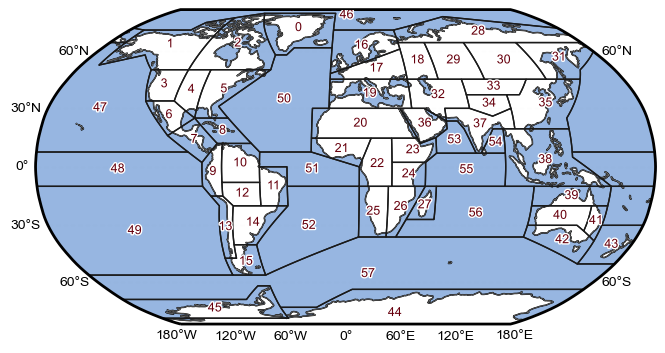

In [8]:
import matplotlib.patheffects as pe


def plot_background(ax):
    ax.add_feature(cfeature.COASTLINE, alpha=0.9, lw=1.1)
    ax.set_global()
    # ax.add_feature(cfeature.LAND, color='lightgray')
    # ax.add_feature(cfeature.OCEAN, color='lightgray')
    gl = ax.gridlines(draw_labels=True,
                      linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    # gl.left_labels = False
    # gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    # gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    return ax


fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection = ccrs.Robinson())
ax.coastlines(lw=0.7, alpha=0.7)
plot_background(ax)
text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=9,
)
regionmask.defined_regions.ar6.all.plot(text_kws=text_kws, label = "number", line_kws=dict(lw=1), add_ocean=True)
plt.savefig('./images/regions.png', dpi=300, bbox_inches='tight')

In [9]:
ar6_mask = regionmask.defined_regions.ar6.all.mask_3D(best.temperature)

In [10]:
# def get_all_regional_trends(glob_temp, mask):
#     slope_reg = np.empty((len(mask.region), 44, 44))
#     pval_reg = np.empty((len(mask.region), 44, 44))
#     duration_reg = np.empty((len(mask.region), 44, 44))
#     for reg_idx in range(len(mask.region)):
#         reg_mean = preprocess_temp.calc_gmst(glob_temp.where(mask.isel(region = reg_idx)))
#         reg_smooth = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(reg_mean.ffill('year').bfill('year')), year = reg_mean['year'].to_numpy())).set_index('year').to_xarray().temp_smooth
#         _, _, slope_reg[reg_idx, :, :], pval_reg[reg_idx, :, :], duration_reg[reg_idx, :, :] = trend_analysis.get_all_trends(reg_smooth, initial_dur=30)
#         print(f'Completed {reg_idx + 1}/{len(mask.region)}', end='\r')
#     return slope_reg, pval_reg, duration_reg


# def get_all_regional_accl(glob_temp, mask, duration=100):
#     accl_reg = np.empty((len(mask.region)))
#     pval_reg = np.empty((len(mask.region)))
#     for reg_idx in range(len(mask.region)):
#         reg_mean = preprocess_temp.calc_gmst(glob_temp.where(mask.isel(region = reg_idx)))
#         reg_smooth = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(reg_mean.ffill('year').bfill('year')), year = reg_mean['year'].to_numpy())).set_index('year').to_xarray().temp_smooth
#         accl_reg[reg_idx] = accl_analysis.calc_accl1d(reg_smooth, duration=duration, gap=4)
#         pval_reg[reg_idx] = accl_analysis.calc_pval1d(reg_smooth, duration=duration, gap=4)
#         print(f'Completed {reg_idx + 1}/{len(mask.region)}', end='\r')
#     return accl_reg, pval_reg

In [11]:
# slope_reg, pval_reg, duration_reg = get_all_regional_trends(best.temperature, ar6_mask)

In [12]:
# accl_reg, accl_pval_reg = get_all_regional_accl(best.temperature, ar6_mask, duration=32)

In [13]:
# out_reg_trends = xr.Dataset(
#     data_vars=dict(
#         slope = (["region", "sy", "ey"], slope_reg),
#         pval = (["region", "sy", "ey"], pval_reg),
#         duration = (["region", "sy", "ey"], duration_reg),
#     ),
#     coords=dict(
#         region = (["region"], ar6_mask.region.names.to_numpy()),
#         sy = (["sy"], np.arange(1850, 2026, 4)),
#         ey = (["ey"], np.arange(1850, 2026, 4)),
#     )
# )
# out_reg_trends

In [14]:
# out_reg_accl = xr.Dataset(
#     data_vars=dict(
#         accl = (["region"], accl_reg),
#         pval = (["region"], accl_pval_reg),
#     ),
#     coords=dict(
#         region = (["region"], ar6_mask.region.names.to_numpy()),
#     )
# )
# out_reg_accl

In [14]:
# out_reg_trends.to_netcdf('./data/results/accl/reg_trends.nc')

In [15]:
# out_reg_accl.to_netcdf('./data/results/accl/reg_accl30.nc')

In [15]:
out_reg_trends = xr.open_dataset('./data/results/trends/reg_trends.nc')

out_reg_accl100 = xr.open_dataset('./data/results/accl/reg_accl100.nc')
out_reg_accl70 = xr.open_dataset('./data/results/accl/reg_accl70.nc')
out_reg_accl50 = xr.open_dataset('./data/results/accl/reg_accl50.nc')
out_reg_accl30 = xr.open_dataset('./data/results/accl/reg_accl30.nc')

In [16]:
slope = out_reg_trends.isel(region=0).slope
duration = out_reg_trends.isel(region=0).duration
pval = out_reg_trends.isel(region=0).pval

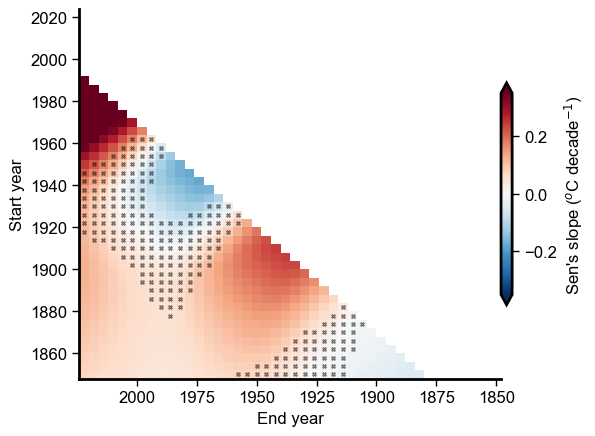

In [17]:
x, y = np.meshgrid(out_reg_trends.ey, out_reg_trends.sy)
cf =  plt.pcolormesh(x, y, slope, cmap='RdBu_r', vmin=-0.35, vmax=0.35)
# cf =  plt.pcolormesh(x, y, duration, cmap='Spectral_r')
plt.scatter(x[pval > 0.05], y[pval > 0.05], color='k', marker='x', s=7, alpha=0.5)
zm = np.ma.masked_less(pval, 0.05)
# plt.pcolor(x, y, zm, hatch='//', alpha=0.)
plt.colorbar(cf, shrink=0.6, pad=0., extend='both', label="Sen's slope ($^{o}$C decade$^{-1}$)")
plt.gca().invert_xaxis()
plt.ylabel('Start year')
plt.xlabel('End year')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.title('greenland trends')# 

In [18]:
trends100 = out_reg_trends.where(out_reg_trends.duration == 100, drop=True)
trends70 = out_reg_trends.where(out_reg_trends.duration == 72, drop=True)
trends50 = out_reg_trends.where(out_reg_trends.duration == 52, drop=True)
trends30 = out_reg_trends.where(out_reg_trends.duration == 32, drop=True)
trends100

<xarray.Dataset>
Dimensions:   (region: 58, sy: 19, ey: 19)
Coordinates:
  * region    (region) object 'Greenland/Iceland' ... 'Southern-Ocean'
  * sy        (sy) int64 1850 1854 1858 1862 1866 ... 1906 1910 1914 1918 1922
  * ey        (ey) int64 1950 1954 1958 1962 1966 ... 2006 2010 2014 2018 2022
Data variables:
    slope     (region, sy, ey) float64 0.07397 nan nan nan ... nan nan 0.1085
    pval      (region, sy, ey) float64 0.09157 nan nan nan ... nan nan 3.871e-06
    duration  (region, sy, ey) float64 100.0 nan nan nan ... nan nan nan 100.0

In [19]:
def get_res(trends):
    slopes = np.empty((len(trends.region), len(trends.ey)))
    pvals = np.empty((len(trends.region), len(trends.ey)))
    accl = np.empty((len(trends.region)))
    accl_pval = np.empty((len(trends.region)))
    for reg_idx in range(len(trends.region)):
        slopes[reg_idx, :] = np.diag(trends.isel(region = reg_idx).slope.to_numpy())
        pvals[reg_idx, :] = np.diag(trends.isel(region = reg_idx).pval.to_numpy())
        res1 = stats.linregress((2022 - trends.ey.to_numpy()), slopes[reg_idx, :])
        accl[reg_idx] = -res1.slope
        accl_pval[reg_idx] = res1.pvalue
    return slopes, pvals, accl, accl_pval

In [20]:
slopes100, pvals100, accl100, accl_pval100 = get_res(trends100)
slopes70, pvals70, accl70, accl_pval70 = get_res(trends70)
slopes50, pvals50, accl50, accl_pval50 = get_res(trends50)
slopes30, pvals30, accl30, accl_pval30 = get_res(trends30)

In [21]:
import seaborn as sns

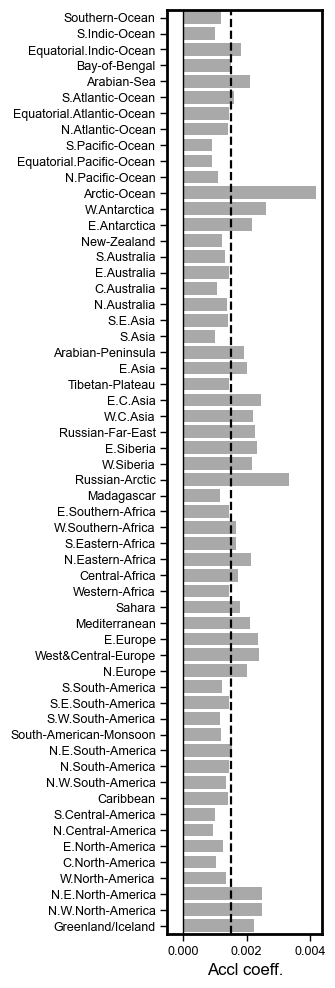

In [22]:
plt.figure(figsize=(2,12))
bar = sns.barplot(x=out_reg_accl30.accl.to_numpy()[::-1], y=trends30.region.to_numpy()[::-1], color='darkgray')
plt.xlim(-0.0005, 0.0044)
plt.axvline(0.0, color='k', lw=1.0)
plt.axvline(0.0015, color='k', lw=1.6, ls='--')
plt.yticks(fontsize=9)
plt.xticks(fontsize=9)
plt.xlabel('Accl coeff.')
for i,thisbar in enumerate(bar.patches):
    if (out_reg_accl30.pval.to_numpy()[::-1])[i] > 0.05:
    # Set a different hatch for each bar
        thisbar.set_hatch('/////')

plt.savefig('./images/reg_plots/bars30.png', dpi=300, bbox_inches='tight')

In [52]:
xx, yy = np.meshgrid(np.arange(len(trends30.ey)), np.arange(len(trends30.region)))

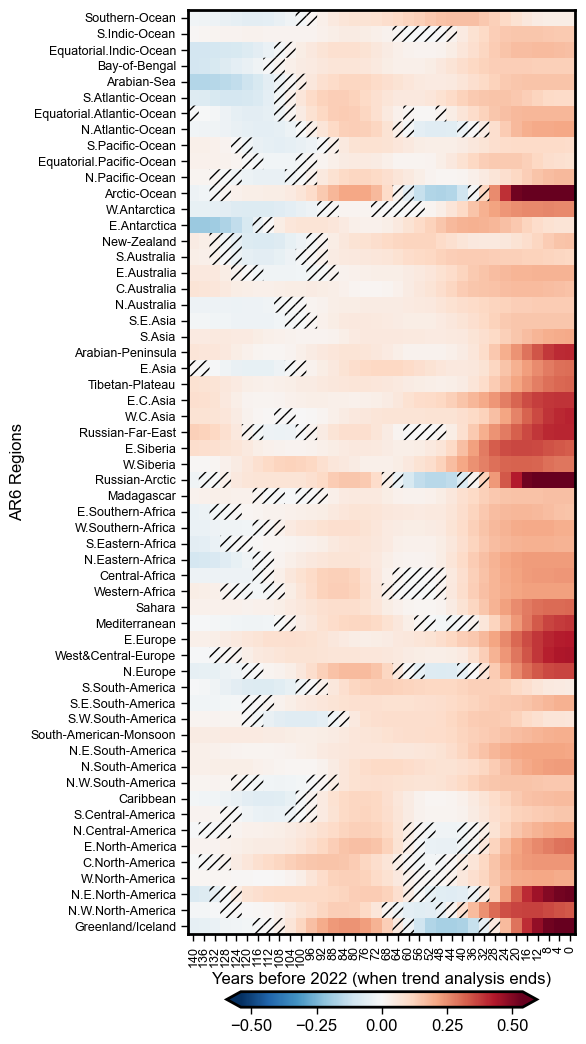

In [53]:
plt.figure(figsize=(5,15))
plt.pcolormesh(xx, yy, slopes30)
trend_mask = np.ma.masked_less_equal(pvals30, 0.05)
cf = plt.pcolormesh(xx, yy, slopes30, cmap = 'RdBu_r', vmin=-0.54, vmax=0.54)
plt.colorbar(cf, extend='both', shrink=0.8, orientation='horizontal', pad=0.05)
plt.pcolor(xx, yy, trend_mask, alpha=0., hatch='///')
plt.xticks(np.arange(len(trends30.ey)), fontsize=9, rotation=90)
plt.yticks(np.arange(len(trends30.region)), fontsize=9)
plt.gca().set_yticklabels(trends30.region.to_numpy())
plt.gca().set_xticklabels([str(j) for j in 2022-trends30.ey.to_numpy()])
plt.ylabel('AR6 Regions')
plt.xlabel('Years before 2022 (when trend analysis ends)')
plt.savefig('./images/reg_plots/map30.png', dpi=300, bbox_inches='tight')

In [24]:
df_int = (((out_reg_accl30.accl - out_reg_accl100.accl)/np.abs(out_reg_accl100.accl))*100).to_dataframe()

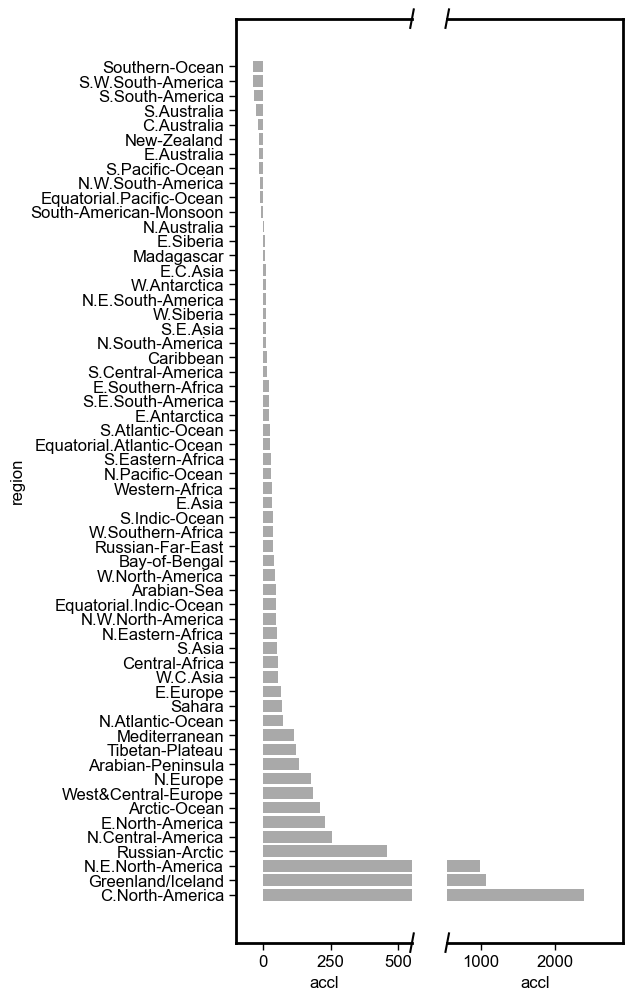

In [74]:
# plt.figure(figsize=(5,12))
f, (ax, ax2) = plt.subplots(1,2, sharey=True, facecolor='white', figsize=(5,12))
bar1 = sns.barplot(x=df_int.sort_values(by='accl')['accl'], y=df_int.sort_values(by='accl').index, color='darkgray', ax=ax)
bar2 = sns.barplot(x=df_int.sort_values(by='accl')['accl'], y=df_int.sort_values(by='accl').index, color='darkgray', ax=ax2)
# plt.xlim(-100, 200)
ax.set_xlim(-100, 550)
ax2.set_xlim(550, 2920)
# plt.axvline(0.0, color='k', lw=1.0)
# plt.axvline(100.0, color='k', lw=1.0, ls='--')

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
bar.yaxis.tick_left()
bar.tick_params(labelright='off')
# ax2.tick_params(labelleft='off', left=False)
# bar2.yaxis.tick_right()
bar2.tick_params(right=False, left=False)
bar2.set_ylabel('')

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
# (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)